In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from seaborn import heatmap
from seaborn import pairplot
from besos import eppy_funcs as ef
from besos import sampling
from besos.evaluator import EvaluatorEP
from besos.parameters import RangeParameter, CategoryParameter, expand_plist, FieldSelector, Parameter, wwr
from besos.problem import EPProblem
plt.rcParams['figure.figsize'] = [8, 8]

In [41]:
filename = 'model_final_triple'
#building = ef.ge t_building('/home/ict4bd/'+filename+'.idf')
building = ef.get_building('/home/brendan/Desktop/polito/ICTBuilding/labBuilding/'+filename+'.idf')

In [42]:
[materials.Name for materials in building.idfobjects["MATERIAL"]] # get a list of the Name property of all IDF objects of class MATERIAL

['Cast Concrete (Dense)_.1',
 'Asphalt 1_.O1',
 'MW Glass Wool (rolls)_.1445',
 'Plasterboard_.O13',
 'Gypsum Plasterboard_.O25',
 'Cement/plaster/mortar - cement_.O3',
 'XPS Extruded Polystyrene  - CO2 Blowing_.2',
 'Aerated Concrete Block_.2']

In [43]:
building.idfobjects["BUILDING"][0]


Building,
    Building,                 !- Name
    0,                        !- North Axis
    Suburbs,                  !- Terrain
    0.04,                     !- Loads Convergence Tolerance Value
    0.4,                      !- Temperature Convergence Tolerance Value
    FullExterior,             !- Solar Distribution
    25,                       !- Maximum Number of Warmup Days
    6;                        !- Minimum Number of Warmup Days

In [44]:
insulation = FieldSelector(class_name='Material',\
                           object_name='XPS Extruded Polystyrene  - CO2 Blowing_.2',\
                           field_name='Thickness')
ach_bedroom = FieldSelector(class_name='ZoneVentilation:DesignFlowRate',object_name='Block1:Bedroom Nat Vent', field_name='Air Changes per Hour')
ach_bathroom=FieldSelector(class_name='ZoneVentilation:DesignFlowRate',object_name='Block1:Bathroom Nat Vent', field_name='Air Changes per Hour')
ach_kitchen=FieldSelector(class_name='ZoneVentilation:DesignFlowRate',object_name='Block1:Kitchen Nat Vent', field_name='Air Changes per Hour')
shading_bedroom = FieldSelector(class_name='WindowShadingControl',object_name='1001-Block1:Bedroom', field_name='Setpoint')
shading_bathroom = FieldSelector(class_name='WindowShadingControl',object_name='1002-Block1:Bathroom', field_name='Setpoint')
shading_kitchen = FieldSelector(class_name='WindowShadingControl',object_name='1003-Block1:Kitchen', field_name='Setpoint')
orientation = FieldSelector(class_name='Building',object_name='Building',field_name='North Axis')

In [45]:
zero_to_one_exclusive = CategoryParameter(options=[0.00001, 0.10, 0.20])
ach_parameters = CategoryParameter(options=[0,5])
shading_parameters = CategoryParameter(options=[120,2000])
orientation_parameters = CategoryParameter(options=[0.0, 90.0, 180.0, 270.0])

In [46]:
insulation_param = Parameter(selector=insulation,
                                 value_descriptor=zero_to_one_exclusive,
                                 name='Insulation Thickness')

ach_bedroom_param = Parameter(selector=ach_bedroom,
                                 value_descriptor=ach_parameters,
                                 name='Air Changes per Hour Bedroom')

ach_bathroom_param = Parameter(selector=ach_bathroom,
                                 value_descriptor=ach_parameters,
                                 name='Air Changes per Hour Bathroom')

ach_kitchen_param = Parameter(selector=ach_kitchen,
                                 value_descriptor=ach_parameters,
                                 name='Air Changes per Hour Kitchen')

shading_bedroom_param=Parameter(selector=shading_bedroom,
                                 value_descriptor=shading_parameters,
                                 name='Shading Bedroom')

shading_bathroom_param=Parameter(selector=shading_bathroom,
                                 value_descriptor=shading_parameters,
                                 name='Shading Bathroom')

shading_kitchen_param=Parameter(selector=shading_kitchen,
                                 value_descriptor=shading_parameters,
                                 name='Shading Kitchen')

orientation_param = Parameter(selector = orientation, 
                              value_descriptor = orientation_parameters, 
                              name = 'Orientation')


In [47]:
window_to_wall = wwr(RangeParameter(0.1,0.9)) # use a special shortcut to get the window-to-wall parameter
window_to_wall

Parameter(name='Window to Wall Ratio', selector=wwrSelector(), value_descriptor=RangeParameter(min=0.1, max=0.9))

In [48]:
# Add all the parameters to a single parameters object.
#parameters = [insulation_param] + [window_to_wall]
parameters = [window_to_wall,insulation_param,orientation_param,ach_bedroom_param,ach_bathroom_param,ach_kitchen_param,shading_bedroom_param,shading_bathroom_param,shading_kitchen_param] 
parameters2 = [insulation_param,ach_bedroom_param,shading_bedroom_param,orientation_param,window_to_wall]
# Let us try to optimize the Cooling and the Heating of facility at the same time
objectives = ['Electricity:Facility','DistrictCooling:Facility'] 
#'InteriorLights:Electricity' has correlation circa 1 with ELectricity:Facility, we remove it from the obj
# These are hourly values, default is sum all the hourly values

# Construct the problem 
problem = EPProblem(parameters2, objectives) # Make a problem instance from the parameters and objectives

In [49]:
for param in parameters2:
    print(param)
    print("\n")

Parameter(name='Insulation Thickness', selector=FieldSelector(field_name='Thickness', class_name='Material', object_name='XPS Extruded Polystyrene  - CO2 Blowing_.2'), value_descriptor=CategoryParameter(options=[1e-05, 0.1, 0.2]))


Parameter(name='Air Changes per Hour Bedroom', selector=FieldSelector(field_name='Air Changes per Hour', class_name='ZoneVentilation:DesignFlowRate', object_name='Block1:Bedroom Nat Vent'), value_descriptor=CategoryParameter(options=[0, 5]))


Parameter(name='Shading Bedroom', selector=FieldSelector(field_name='Setpoint', class_name='WindowShadingControl', object_name='1001-Block1:Bedroom'), value_descriptor=CategoryParameter(options=[120, 2000]))


Parameter(name='Orientation', selector=FieldSelector(field_name='North Axis', class_name='Building', object_name='Building'), value_descriptor=CategoryParameter(options=[0.0, 90.0, 180.0, 270.0]))


Parameter(name='Window to Wall Ratio', selector=wwrSelector(), value_descriptor=RangeParameter(min=0.1, max=0.9))


In [50]:
#samples = sampling.dist_sampler(sampling.lhs, problem, num_samples=20)
import numpy as np
W_wwr = [0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]
new_wwr= np.linspace(0.1,0.9,30)
dictio = {"insulation":[0.00001,0.10,0.20,0.00001,0.10,0.20,0.00001,0.10,0.20,0.00001,0.10,0.20],\
          "ach":[5,5,5,5,5,5,0,0,0,0,0,0], \
          "shading":[120,120,120,120,120,120,2000,2000,2000,2000,2000,2000],\
          "orientation":[0,0,0,90,90,90,0,0,0,90,90,90],\
          "wwr":[new_wwr for x in range(12)]}
samples = pd.DataFrame(dictio)
#samples = pd.read_csv(filename+'.csv').drop(['Electricity:Facility','DistrictCooling:Facility'], axis=1)
samples
new_wwr

array([0.1       , 0.12758621, 0.15517241, 0.18275862, 0.21034483,
       0.23793103, 0.26551724, 0.29310345, 0.32068966, 0.34827586,
       0.37586207, 0.40344828, 0.43103448, 0.45862069, 0.4862069 ,
       0.5137931 , 0.54137931, 0.56896552, 0.59655172, 0.62413793,
       0.65172414, 0.67931034, 0.70689655, 0.73448276, 0.76206897,
       0.78965517, 0.81724138, 0.84482759, 0.87241379, 0.9       ])

In [51]:
new_samples = samples.explode("wwr")
new_samples.reset_index(inplace=True,drop=True)
new_samples

,insulation,ach,shading,orientation,wwr
0,0.00001,5,120,0,0.1
1,0.00001,5,120,0,0.127586
2,0.00001,5,120,0,0.155172
3,0.00001,5,120,0,0.182759
4,0.00001,5,120,0,0.210345
...,...,...,...,...,...
355,0.20000,0,2000,90,0.789655
356,0.20000,0,2000,90,0.817241
357,0.20000,0,2000,90,0.844828
358,0.20000,0,2000,90,0.872414


In [52]:
new_samples.describe

<bound method NDFrame.describe of      insulation  ach  shading  orientation       wwr
0       0.00001    5      120            0       0.1
1       0.00001    5      120            0  0.127586
2       0.00001    5      120            0  0.155172
3       0.00001    5      120            0  0.182759
4       0.00001    5      120            0  0.210345
..          ...  ...      ...          ...       ...
355     0.20000    0     2000           90  0.789655
356     0.20000    0     2000           90  0.817241
357     0.20000    0     2000           90  0.844828
358     0.20000    0     2000           90  0.872414
359     0.20000    0     2000           90       0.9

[360 rows x 5 columns]>

In [53]:
evaluator = EvaluatorEP(problem, building, out_dir='outputdir', err_dir='outputdir',epw='../larnaca.epw')


In [54]:
outputs = evaluator.df_apply(new_samples, keep_input=True)
outputs.describe()

,insulation,ach,shading,orientation,Electricity:Facility,DistrictCooling:Facility
count,360.000000,360.000000,360.000000,360.000000,3.600000e+02,3.600000e+02
mean,0.100003,2.500000,1060.000000,45.000000,3.741403e+09,9.363231e+09
std,0.081759,2.503479,941.308282,45.062631,1.720727e+08,1.316298e+09
min,0.000010,0.000000,120.000000,0.000000,3.512692e+09,7.113233e+09
25%,0.000010,0.000000,120.000000,0.000000,3.589878e+09,8.253510e+09
50%,0.100000,2.500000,1060.000000,45.000000,3.708465e+09,9.326180e+09
75%,0.200000,5.000000,2000.000000,90.000000,3.873422e+09,1.027546e+10
max,0.200000,5.000000,2000.000000,90.000000,4.112009e+09,1.216862e+10


<Figure size 864x864 with 0 Axes>

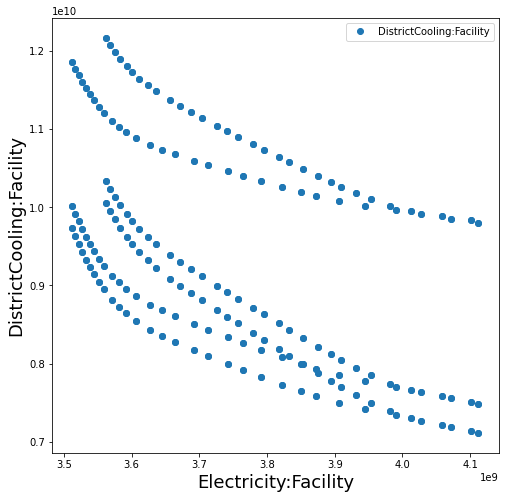

In [64]:
plt.figure(figsize=(12,12))

gigi = outputs.plot(x=objectives[0], y=objectives[1], style = 'o')
plt.xlabel(objectives[0],fontsize=18)
plt.ylabel(objectives[1],fontsize=18)
plt.savefig('EnergyvsDistrict.png',dpi=200)

In [56]:
outputs

,insulation,ach,shading,orientation,wwr,Electricity:Facility,DistrictCooling:Facility
0,0.00001,5,120,0,0.1,4.112009e+09,9.798874e+09
1,0.00001,5,120,0,0.127586,4.071393e+09,9.852644e+09
2,0.00001,5,120,0,0.155172,4.027781e+09,9.912038e+09
3,0.00001,5,120,0,0.182759,3.990565e+09,9.960259e+09
4,0.00001,5,120,0,0.210345,3.944312e+09,1.002249e+10
...,...,...,...,...,...,...,...
355,0.20000,0,2000,90,0.789655,3.592685e+09,9.625481e+09
356,0.20000,0,2000,90,0.817241,3.583331e+09,9.737693e+09
357,0.20000,0,2000,90,0.844828,3.575488e+09,9.845313e+09
358,0.20000,0,2000,90,0.872414,3.568560e+09,9.947782e+09


In [57]:
print(len(new_wwr))
print(range(int(len(outputs)/len(new_wwr))))
print(int(len(outputs)))

30
range(0, 12)
360


In [58]:
print(outputs[:][0:60])
outputs.to_csv("outputs_360.csv")

    insulation  ach  shading  orientation       wwr  Electricity:Facility  \
0      0.00001    5      120            0       0.1          4.112009e+09   
1      0.00001    5      120            0  0.127586          4.071393e+09   
2      0.00001    5      120            0  0.155172          4.027781e+09   
3      0.00001    5      120            0  0.182759          3.990565e+09   
4      0.00001    5      120            0  0.210345          3.944312e+09   
5      0.00001    5      120            0  0.237931          3.906031e+09   
6      0.00001    5      120            0  0.265517          3.872894e+09   
7      0.00001    5      120            0  0.293103          3.850193e+09   
8      0.00001    5      120            0   0.32069          3.822551e+09   
9      0.00001    5      120            0  0.348276          3.791492e+09   
10     0.00001    5      120            0  0.375862          3.764237e+09   
11     0.00001    5      120            0  0.403448          3.742576e+09   

In [70]:
count=0
plt.figure(figsize=(10,10))
achON_OFF = 0
Orientation_0_270 = 0

for i in range(int(len(outputs)/len(new_wwr))):
    
    if new_samples["ach"][i*len(new_wwr)] == achON_OFF \
        and new_samples["orientation"][i*len(new_wwr)] == Orientation_0_270:

        #plt.plot(new_wwr,outputs["Electricity:Facility"][i*30:i*30+30],label="thickness="+str(new_samples["insulation"][i*len(new_wwr)]))
        plt.plot(new_wwr,outputs["DistrictCooling:Facility"][i*30:i*30+30],label="thickness="+str(new_samples["insulation"][i*len(new_wwr)]))
        print(i)
        plt.legend()
        plt.grid()
        plt.xlabel("WWR",fontsize=18)
        plt.ylabel("Energy Consumption",fontsize=18)
plt.savefig("ach" + +""+".png",dpi=300)

<Figure size 720x720 with 0 Axes>

In [60]:
plt.figure(figsize=(10,10))
count=0
for i in range(int(len(outputs)/len(new_wwr))):
    if new_samples["ach"][i*len(new_wwr)] == 0 and new_samples["orientation"][i*len(new_wwr)] == 270:
        #plt.plot(new_wwr,outputs["Electricity:Facility"][i*30:i*30+30],label="thickness="+str(new_samples["insulation"][i*len(new_wwr)]))
        plt.plot(new_wwr,outputs["DistrictCooling:Facility"][i*30:i*30+30],label="thickness="+str(new_samples["insulation"][i*len(new_wwr)]))
        print(i)
        plt.legend()
        plt.grid()
        plt.xlabel("WWR")
        plt.ylabel("Energy Consumption")
plt.savefig("achOFF-Nord.png",dpi=300)

<Figure size 720x720 with 0 Axes>

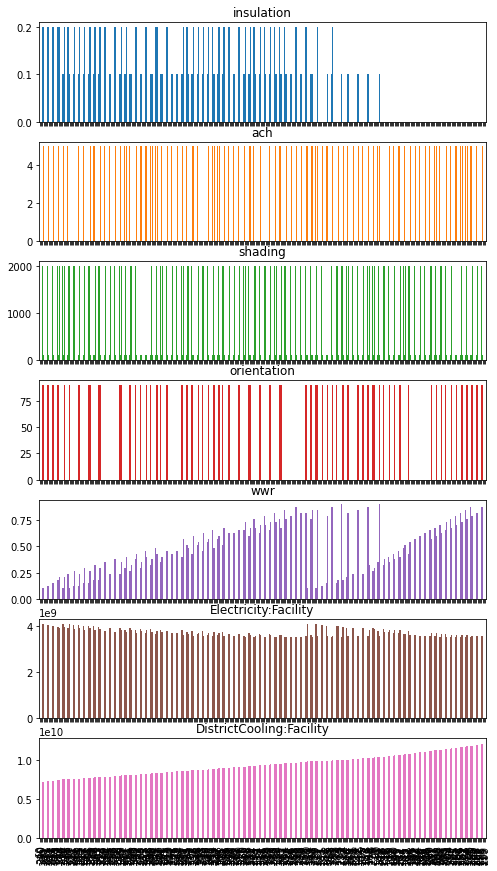

In [61]:
outputs_sorted = outputs.sort_values(by=objectives[1])
ax=outputs_sorted.plot.bar(subplots=True,legend=None, figsize=(8,15))
#outputs.to_csv(filename + '_orientation' + '.csv', index = False)

In [62]:
outputs_sorted

,insulation,ach,shading,orientation,wwr,Electricity:Facility,DistrictCooling:Facility
60,0.20000,5,120,0,0.1,4.112009e+09,7.113233e+09
240,0.20000,0,2000,0,0.1,4.112009e+09,7.113233e+09
330,0.20000,0,2000,90,0.1,4.101614e+09,7.138045e+09
150,0.20000,5,120,90,0.1,4.101614e+09,7.138045e+09
61,0.20000,5,120,0,0.127586,4.071393e+09,7.190869e+09
...,...,...,...,...,...,...,...
297,0.00001,0,2000,90,0.844828,3.575488e+09,1.199087e+10
298,0.00001,0,2000,90,0.872414,3.568560e+09,1.207804e+10
118,0.00001,5,120,90,0.872414,3.568560e+09,1.207804e+10
119,0.00001,5,120,90,0.9,3.562110e+09,1.216862e+10


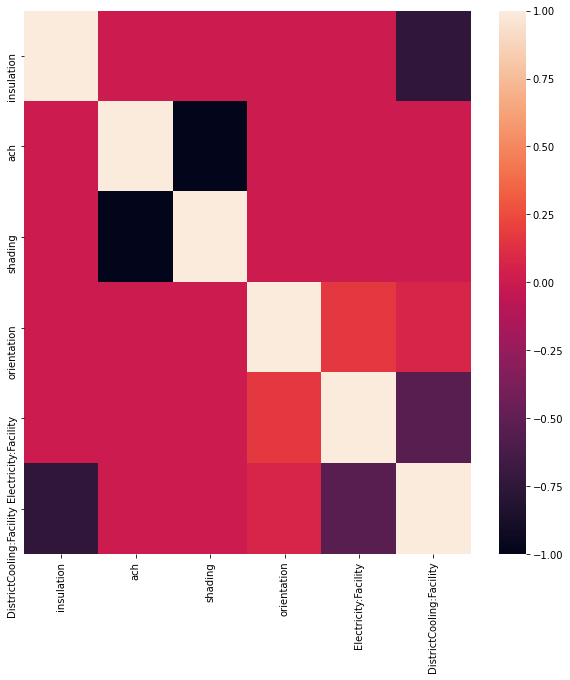

In [66]:
plt.figure(figsize=(10,10))
gigi = heatmap(outputs.corr())
plt.savefig('heatmap_params.png')